In [38]:
setwd("..")
suppressPackageStartupMessages(source("tree_helper_function.R"))
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tAfterBHMoreClimbMIRV.RData")
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree.RData")
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/y.RData")
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/yAll.RData")
load()

In [27]:
ndtes <- which(mcols(y)[["qvalue"]] > 0.1 | is.na(mcols(y)[["qvalue"]])) ##non differentially expressed transcripts
length(ndtes)

[1] 122881

In [17]:
innNodes <- tAfterBHMoreClimbMIRV[[3]][[3]][tAfterBHMoreClimbMIRV[[3]][[3]] > length(tree$tip)]
length(innNodes)

In [29]:
desc <- Descendants(tree, innNodes)
innNdte <- innNodes[sapply(desc, function(txps) sum(txps %in% ndtes) == length(txps))] ##Inner nodes that contain only non differentially expressed transcripts
length(innNdte)                           

In [62]:
minPs <- sapply(innNdte, function(node) min(mcols(yAll)[Descendants(tree,node)[[1]],"pvalue"], na.rm=T))
which(minPs > 0.10)

[1]  17  18  39  66  78  83  95 102 116 126 148 169

In [60]:
max(minPs)

[1] 0.2398643

In [105]:
i <- 66
Descendants(tree,innNdte[i])[[1]] %in% ndtes
mcols(yAll)[Descendants(tree,innNdte[i])[[1]], "pvalue"]
mcols(yAll)[innNdte[i], "pvalue"]

[1] TRUE TRUE

[1] 0.2804071 0.1120364

[1] 0.009973344

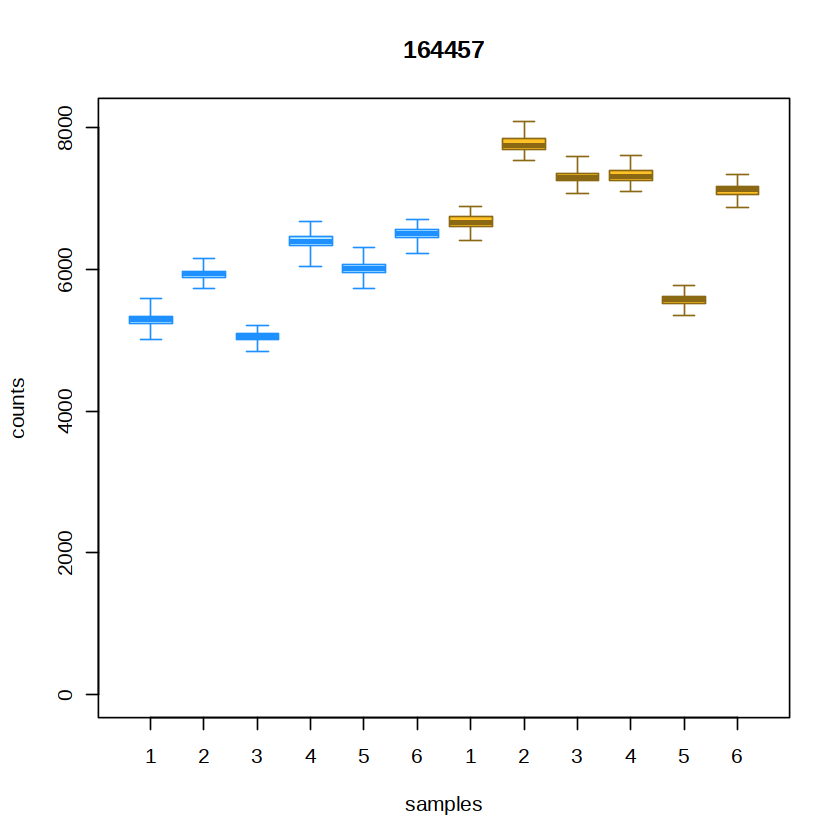

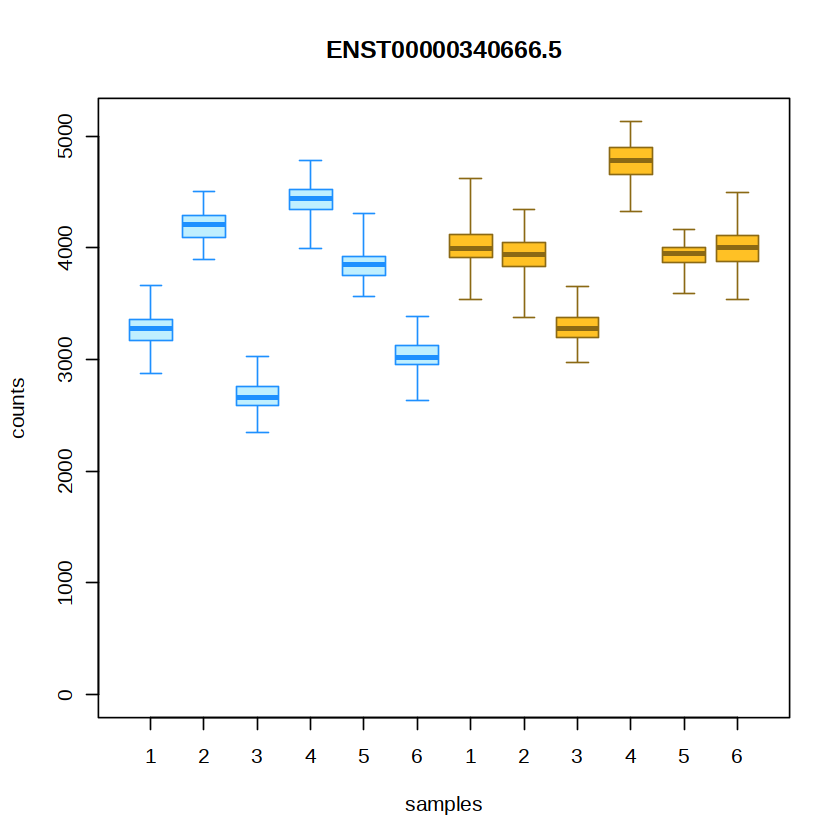

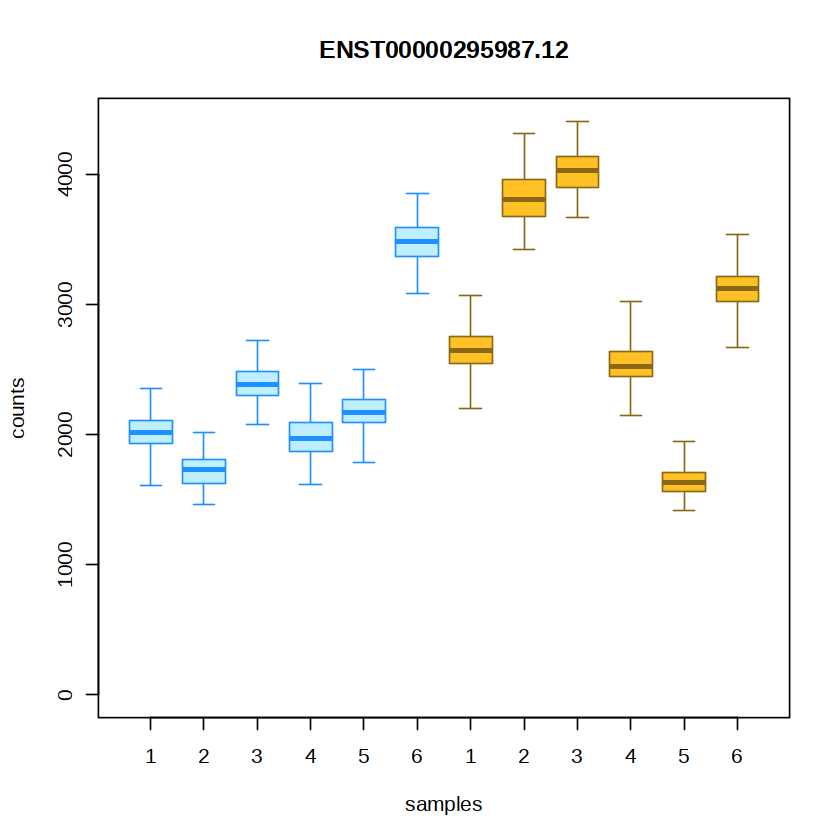

In [102]:
plotInfReps(yAll, idx = innNdte[i], x="condition", )
plotInfReps(yAll, idx = Descendants(tree,innNdte[i])[[1]][1], x="condition", )
plotInfReps(yAll, idx = Descendants(tree,innNdte[i])[[1]][2], x="condition")

In [73]:
plotInfReps

function (y, idx, x, cov = NULL, colsDrk = c("dodgerblue", "goldenrod4", 
    "royalblue4", "red3", "purple4", "darkgreen"), colsLgt = c("lightblue1", 
    "goldenrod1", "royalblue1", "salmon1", "orchid1", "limegreen"), 
    xaxis, xlab, ylim, main, mainCol, legend = FALSE, legendPos = "topleft", 
    legendTitle = FALSE, legendCex = 1, useMean = TRUE, q = qnorm(0.975), 
    applySF = FALSE, reorder, thin, shiftX) 
{
    stopifnot(x %in% names(colData(y)))
    condition <- colData(y)[[x]]
    xfac <- is(condition, "factor")
    if (!xfac) 
        stopifnot(is(condition, "numeric"))
    hasInfReps <- any(grepl("infRep", assayNames(y)))
    drawBoxplot <- hasInfReps & xfac
    stopifnot(length(colsDrk) == length(colsLgt))
    if (xfac) {
        ncond <- nlevels(condition)
        stopifnot(ncond <= length(colsDrk))
        colsDrk <- colsDrk[seq_len(ncond)]
        colsLgt <- colsLgt[seq_len(ncond)]
    }
    if (!drawBoxplot) {
        if (useMean & !("mean" %in% assayNames(y))) {
            message("using 'counts' assay, as 'mean' is missing, see argument 'useMean'")
            useMean <- FALSE
        }
        if (!"variance" %in% assayNames(y)) 
            stop("'variance' assay is missing, use computeInfRV() first")
    }
    if (missing(xaxis)) {
        if (xfac) {
            xaxis <- ncol(y) < 30
        }
        else {
            xaxis <- TRUE
        }
    }
    if (missing(thin)) {
        thin <- if (ncol(y) >= 400) 
            2
        else if (ncol(y) >= 150) 
            1
        else 0
    }
    else {
        stopifnot(thin >= 0 & thin <= 2)
    }
    if (!is.null(cov)) {
        stopifnot(cov %in% names(colData(y)))
        covariate <- factor(colData(y)[[cov]])
        stopifnot(is(covariate, "factor"))
        ngrp <- nlevels(covariate)
    }
    infRepsScaled <- FALSE
    if (!is.null(metadata(y)$infRepsScaled)) {
        infRepsScaled <- metadata(y)$infRepsScaled
    }
    sc <- FALSE
    if (!is.null(metadata(y)$tximetaInfo$type)) {
        if (metadata(y)$tximetaInfo$type == "alevin") {
            sc <- TRUE
        }
    }
    if (missing(xlab)) {
        if (xfac) {
            xlab <- if (sc) 
                "cells"
            else "samples"
        }
        else {
            xlab <- x
        }
    }
    if (missing(reorder)) {
        if (xfac) {
            reorder <- sc
        }
        else {
            reorder <- FALSE
        }
    }
    else {
        if (!xfac & reorder) 
            stop("reorder not used when 'x' is numeric")
    }
    ylab <- if (infRepsScaled) 
        "scaled counts"
    else "counts"
    xlabel <- if (xaxis) 
        xlab
    else ""
    if (missing(main)) {
        if (missing(mainCol)) {
            if (is.character(idx)) {
                main <- idx
            }
            else {
                main <- rownames(y)[idx]
            }
        }
        else {
            stopifnot(mainCol %in% names(mcols(y)))
            main <- mcols(y)[idx, mainCol]
        }
    }
    if (reorder) {
        if (drawBoxplot) {
            infReps <- assays(y[idx, ])[grep("infRep", assayNames(y))]
            value <- colMeans(unlist(infReps))
        }
        else {
            which.assay <- if (useMean) 
                "mean"
            else "counts"
            value <- assays(y)[[which.assay]][idx, ]
            if (applySF & !is.null(y$sizeFactor)) {
                value <- value/y$sizeFactor
            }
        }
        if (is.null(cov)) {
            o <- order(condition, value)
        }
        else {
            o <- order(covariate, condition, value)
        }
    }
    else {
        if (xfac) {
            if (is.null(cov)) {
                o <- order(condition)
            }
            else {
                o <- order(covariate, condition)
            }
        }
        else {
            o <- seq_along(condition)
        }
    }
    if (xfac) {
        if (is.null(cov)) {
            samp.nums <- unlist(lapply(table(condition), seq_len